In [20]:
import numpy as np
import pandas as pd
import os, sys
import glob
from astropy import units as u
import random
import h5py
import itertools
import multiprocessing as mp
import time
import pickle

from astropy.timeseries import BoxLeastSquares, LombScargle
from scipy.signal import find_peaks, peak_widths
from scipy.optimize import minimize, minimize_scalar
from sklearn.preprocessing import MinMaxScaler
from gatspy import datasets, periodic
from scipy.interpolate import UnivariateSpline

import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from matplotlib import rc
from matplotlib import cm
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
plt.style.use('classic')
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
rc('figure', facecolor='w')
rc('xtick', labelsize=20)
rc('ytick', labelsize=20)

sys.path.append('/astro/users/jbirky/projects/tess_binaries')
os.environ['TESS_DATA'] = '/data/epyc/projects2/tess'

import tess_binaries as tb

In [2]:
sample = tb.loadSampleFromHDF5(f'{tb.cat_dir}/asassn_tess_inspected.hdf5')

Loading /astro/users/jbirky/projects/tess_binaries/catalogs/asassn_tess_inspected.hdf5


/epyc/opt/anaconda/lib/python3.6/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [3]:
k = 17
lc = tb.LightCurve(tic_id=sample['tic_id'][k])
lc.powerSpectrum()

(array([[1.00000000e+03, 2.18021988e+02, 1.22348304e+02, ...,
         1.00005576e-02, 1.00001990e-02, 9.99984028e-03],
        [4.11520834e-04, 4.11609451e-04, 4.11802886e-04, ...,
         3.44455928e-06, 6.77617226e-06, 1.04595030e-05]]), 1.4808269575451964)

In [4]:
a = np.linspace(lc.best_period-.05, lc.best_period+.05, 20)
b = np.linspace(2*lc.best_period-.05, 2*lc.best_period+.05, 20)
periods = np.concatenate((a,b))

t0 = time.time()
chivals = tb.phaseDispersionMinimization(lc, window=100, periods=periods)
print(time.time() - t0)

/epyc/opt/anaconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1076: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


51.64720869064331


In [30]:
def PDM(period, window=100, **kwargs):
    
#     lc = kwargs.get('lc')
    lc.phaseFold(period=period)
    lc.smoothData(window=window)

    chi_val = np.nansum(((lc.phase_flux - lc.bin_flux)/lc.phase_flux_err)**2)

    return chi_val

t0 = time.time()
res = minimize_scalar(PDM, bounds=(2*lc.best_period-.1, 2*lc.best_period+.1), method='bounded')
print(time.time() - t0)
res.x

/epyc/opt/anaconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1076: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


19.398065090179443


2.96841625516451

In [45]:
t0 = time.time()
r2 = minimize_scalar(PDM, bounds=(lc.best_period-.1, lc.best_period+.1), method='bounded')
print(time.time() - t0)
r2.x

/epyc/opt/anaconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1076: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


18.469722509384155


1.4842865502008313

In [49]:
r2.fun > res.x

True

Grid search: 2.9695486519324983 1771248.5046131343
Scipy-optimize: 2.96841625516451 150606.55876669753


/epyc/opt/anaconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1076: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


ASASSN: 2.9684589 134759.84935724814


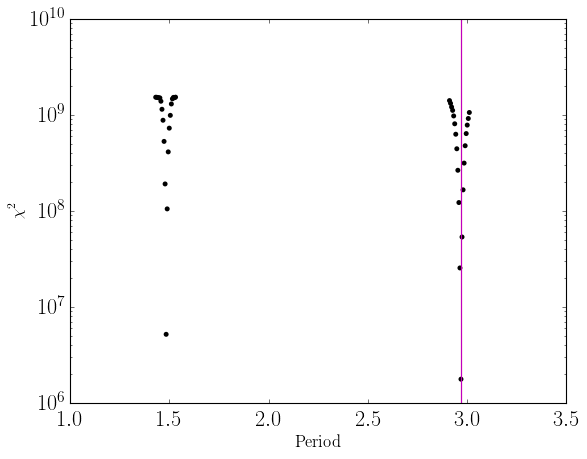

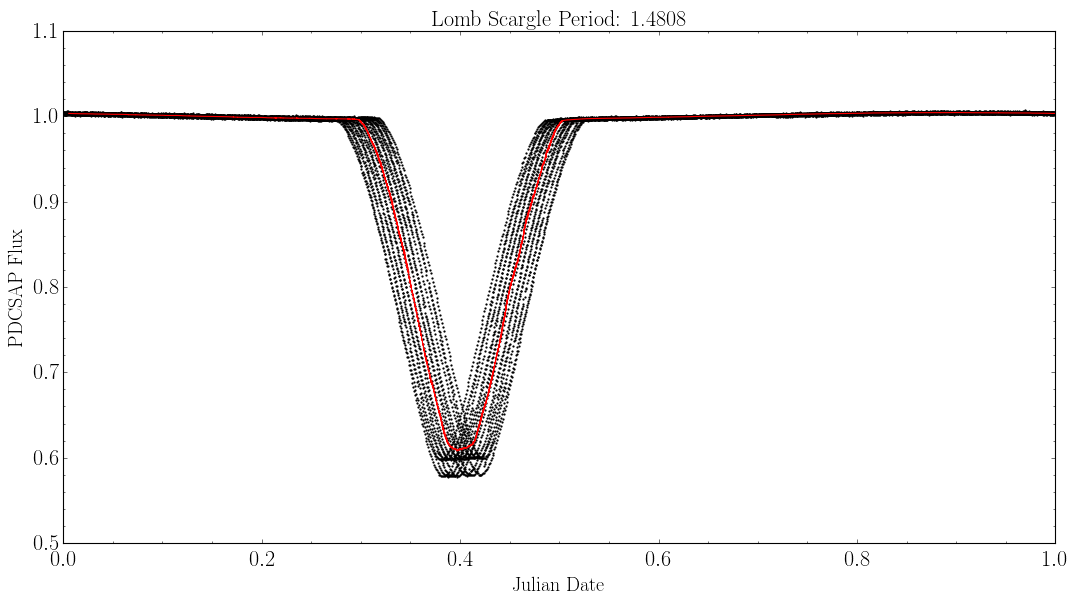

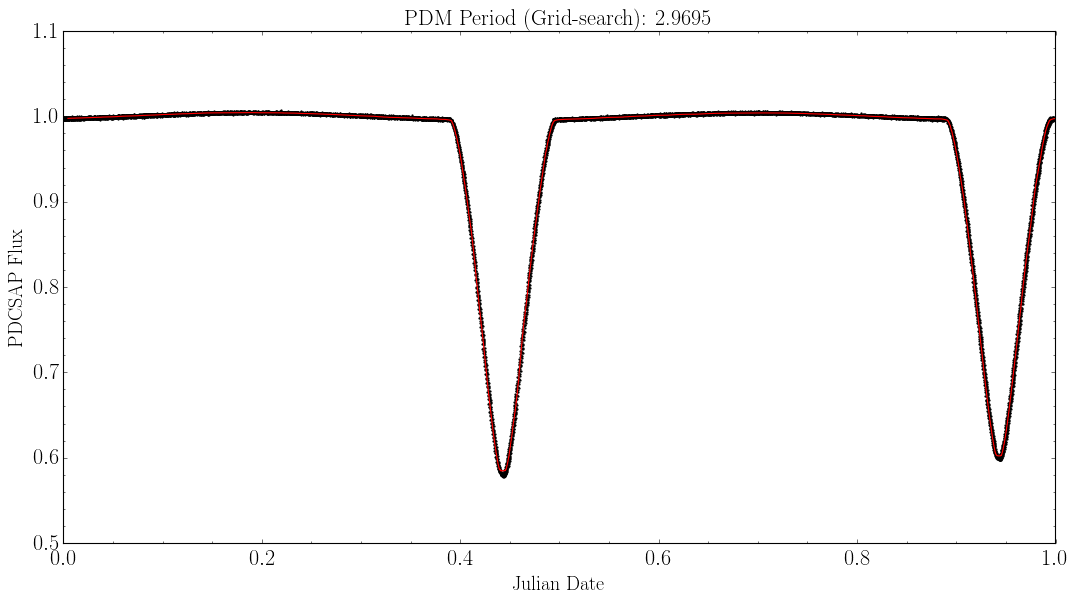

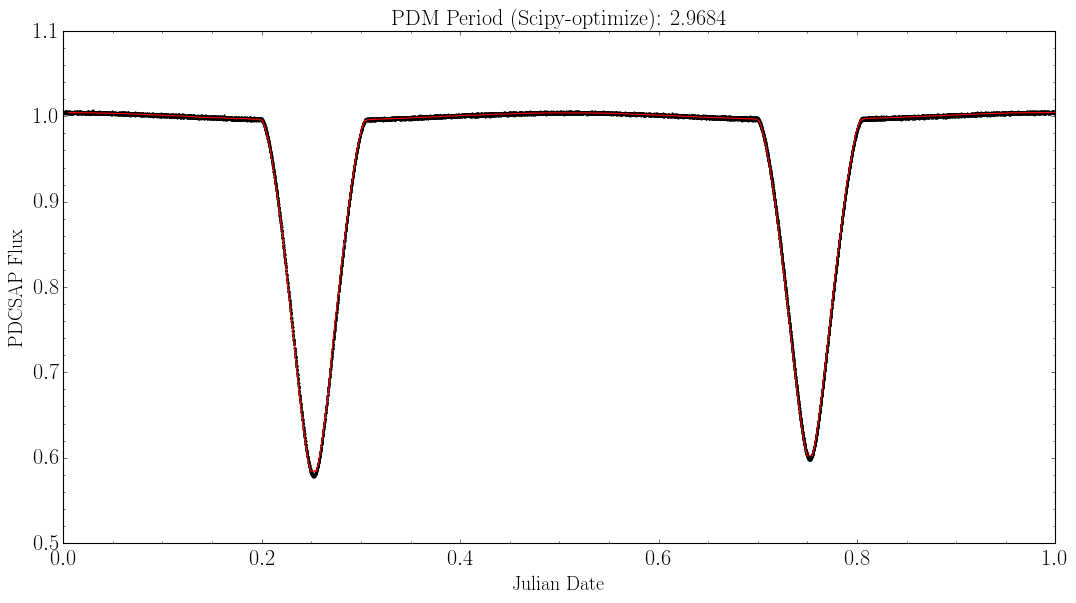

/epyc/opt/anaconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1076: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


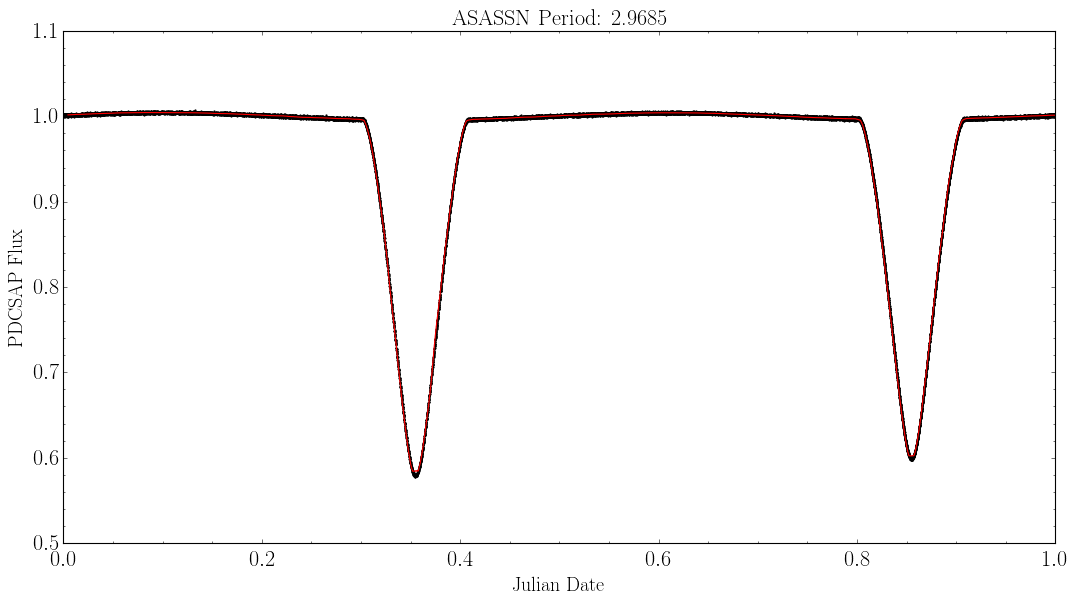

In [41]:
print('Grid search:', periods[np.argmin(chivals)], min(chivals))
print('Scipy-optimize:', res.x, res.fun)
print('ASASSN:', sample['period'][k], PDM(sample['period'][k]))

plt.figure(figsize=[8,6])
plt.scatter(periods, chivals, color='k', edgecolor='none')
plt.axvline(sample['period'][k], color='r')
plt.axvline(periods[np.argmin(chivals)], color='m')
plt.ylabel(r'$\chi^2$', fontsize=15)
plt.xlabel('Period', fontsize=15)
plt.yscale('log')
plt.show()

lc.phaseFold(period=lc.best_period)
lc.smoothData(window=100)
lc.plot(opt='smooth', title=f'Lomb Scargle Period: {round(lc.best_period,4)}')

lc.phaseFold(period=periods[np.argmin(chivals)])
lc.smoothData(window=100)
lc.plot(opt='smooth', title=f'PDM Period (Grid-search): {round(periods[np.argmin(chivals)],4)}')

lc.phaseFold(period=res.x)
lc.smoothData(window=100)
lc.plot(opt='smooth', title=f'PDM Period (Scipy-optimize): {round(res.x,4)}')

lc.phaseFold(period=sample['period'][k])
lc.smoothData(window=100)
lc.plot(opt='smooth', title=f"ASASSN Period: {round(sample['period'][k],4)}")

In [2]:
ff = h5py.File(f'{tb.cat_dir}/asassn_tess_inspected.hdf5', mode="r")

df = {}
for key in list(ff):
    if key == 'type':
        df[key] = np.array(ff[key].value, dtype='str')
    else:
        df[key] = ff[key].value
    
ff.close()
sample = pd.DataFrame(data=df)

/epyc/opt/anaconda/lib/python3.6/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [6]:
ls_period, bls_period = [], []
full_df = []
ls_fold_flux = []

for ID in list(sample['tic_id']):
    infile = open(f'{tb.ps_dir}/{ID}_ps_ls.pkl','rb')
    ps_dict = pickle.load(infile)
    infile.close()
    ls_period.append(ps_dict['ls_best_period'])
    bls_period.append(ps_dict['bls_best_period'])
    full_df.append(ps_dict['data'])

sample['ls_period']  = np.array(ls_period)
sample['bls_period'] = np.array(bls_period)

FileNotFoundError: [Errno 2] No such file or directory: '/astro/users/jbirky/projects/tess_binaries/results/power_spectra/30317282_ps_ls.pkl'

In [355]:
sample_read = sample

In [159]:
def phaseDispersionMinimization(data, periods, tsteps=100):
    
    chi_vals = []
    for per in periods:
        data_fold = data.fold(period=per*u.day)
        time = data_fold.time.jd
        flux = data_fold['pdcsap_flux']
        flux_err = data_fold['pdcsap_flux_err']
        
        tbins = np.linspace(min(time), max(time), tsteps+1)
        bin_flux = []
        chi_sq = []

        for i in range(tsteps):
            bin_ind = np.where((time > tbins[i]) & (time < tbins[i+1]))[0]
            flux_in_bin = flux[bin_ind]
            median_bin_flux = np.nanmedian(flux_in_bin)
            flux_in_bin /= median_bin_flux
            bin_flux.append(median_bin_flux)
            
            chi_sq.append(np.nansum(((flux[bin_ind] - median_bin_flux)/flux_err[bin_ind])**2))
        chi_vals.append(np.sum(chi_sq))
    
    return chi_vals

In [3]:
def phaseDispersionMinimization(data, periods, bin_window=50):
    
    chi_vals = []
    for per in periods:
        data_fold = data.fold(period=per*u.day)
        data_fold.sort('time')
        
        time = data_fold.time.jd
        flux = data_fold['pdcsap_flux']
        flux_err = data_fold['pdcsap_flux_err']
        
        chi_sq = []
        bin_flux = pd.Series(flux).rolling(bin_window, center=True).median()
        bin_time = np.linspace(min(time), max(time), len(bin_flux))
        
        for i, fval in enumerate(flux):
            time_ind = (np.abs(bin_time - time[i])).argmin()
            chi_sq.append(np.nansum(((fval - flux[time_ind])/flux_err[time_ind])**2))

        chi_vals.append(np.sum(chi_sq))
    
    return chi_vals

In [4]:
k = 17
bin_window = 10
data = full_df[k]
mult = [1,2,4]
periods = np.array([sample['ls_period'][k]*i for i in mult])

print(len(data))

print(sample['type'][k])
print(sample['period'][k], sample['ls_period'][k], sample['ls_period'][k]/sample['period'][k])
print('')

chi_vals = phaseDispersionMinimization(data, periods, bin_window=bin_window)
pdm_best = np.argmin(chi_vals)
print(sample['period'][k], periods[pdm_best], periods[pdm_best]/sample['period'][k])

print('')
print(np.round(chi_vals))
print((1 - chi_vals[pdm_best]/chi_vals[0])*100)

plt.scatter(mult, chi_vals/chi_vals[0])
plt.axvline(sample['period'][k]/sample['ls_period'][k], color='r')
plt.ylabel(r'$\chi^2$', fontsize=15)
plt.xlabel('Multiplication factor', fontsize=15)
plt.show()

NameError: name 'full_df' is not defined

In [392]:
min(data_fold['time']), min(data['time'])

(<TimeDelta object: scale='None' format='jd' value=-2.9613084095291966>,
 <Time object: scale='tdb' format='isot' value=2018-07-25T19:10:30.036>)

0.4988537848865607


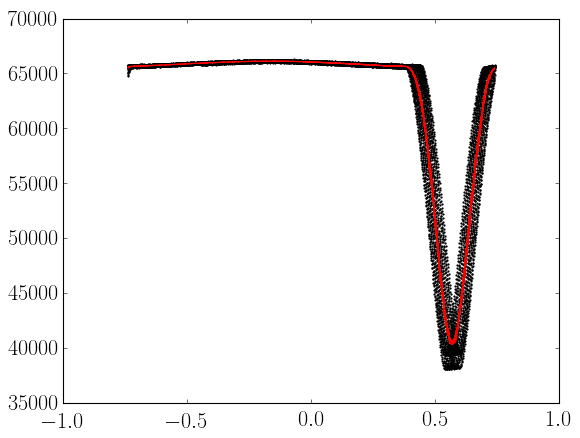

0.9977075697731214


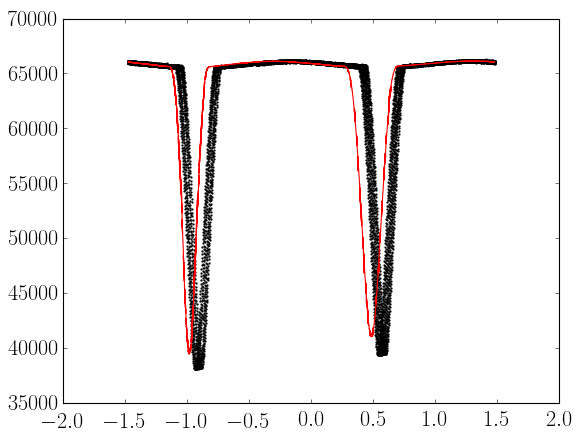

1.9954151395462427


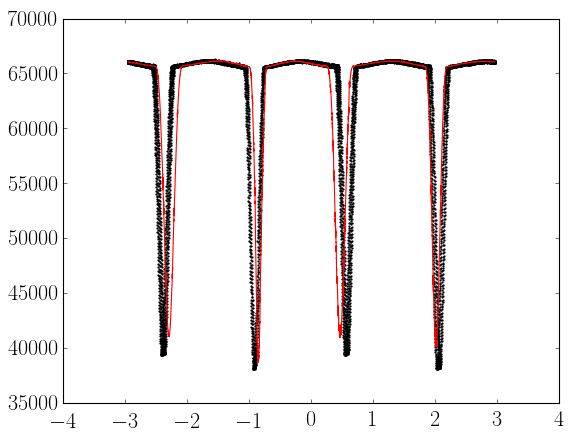

In [385]:
for j, per in enumerate(periods):
    print(per/sample['period'][k])
    
    data = data[~np.isnan(data['pdcsap_flux'])]
    data_fold = data.fold(period=per*u.day)
    data_fold.sort('time')
    
    roll_flux = pd.Series(data_fold['pdcsap_flux']).rolling(20, center=True).mean()
    tt = np.linspace(min(data_fold.time.jd), max(data_fold.time.jd), len(roll_flux))

    plt.scatter(data_fold.time.jd, data_fold['pdcsap_flux'], s=1, color='k')
    plt.plot(tt, roll_flux, color='r')
    plt.show()
    
#     bin_flux = tb.binData(data_fold, tsteps)
#     tarr = np.linspace(min(fold_time), max(fold_time), 10**3)
#     fold_time = np.array(data_fold.time.jd)
#     fold_flux = np.array(data_fold['pdcsap_flux'])
#     fold_flux = fold_flux/np.median(fold_flux)
    
#     tbins = np.linspace(min(fold_time), max(fold_time), tsteps+1)
#     bin_width = (tbins[1] - tbins[0])/2
#     pbins = np.linspace(0,1,tsteps)
    
#     plt.scatter(fold_time, fold_flux, color='k', s=1, label=r'$\chi^2=%s$'%(int(round(chi_vals[j]))))
#     plt.plot(tbins[1:]-bin_width, bin_flux, color='r')
#     plt.scatter(fold_time, spl(fold_time), color='r')
#     plt.title(f"{sample['type'][k]} {mult[j]}x")
#     plt.legend(loc='upper right', scatterpoints=1)
#     plt.show()

In [395]:
data = full_df[k]
data = data[~np.isnan(data['pdcsap_flux'])]
data_fold = data.fold(period=sample['ls_period'][k]*2*u.day)
data_fold.sort('time')

roll_flux = pd.Series(data_fold['pdcsap_flux']).rolling(30).median()
# tt = np.linspace(0,1,len(roll_flux))
tt = np.linspace(min(data_fold.time.jd), max(data_fold.time.jd), len(roll_flux))

plt.scatter(data_fold.time.jd, data_fold['pdcsap_flux'], s=1, color='k')
plt.plot(tt, roll_flux, color='r')
plt.show()

KeyError: 'ls_period'

In [282]:
pdm_period = []
test_periods = [1,2]

t0 = time.time()
for k in range(len(sample)):
    data = full_df[k]
    periods = np.array([sample['ls_period'][k]*i for i in test_periods])
    chi_vals = phaseDispersionMinimization(data, periods, bin_window=50)
    pdm_best = np.argmin(chi_vals)
    pdm_period.append(periods[pdm_best])
    print(k)
sample['pdm_period'] = pdm_period

print(time.time() - t0)

0


KeyboardInterrupt: 

In [354]:
sample[0:10]

,flux,period,tic_id,type,ls_period,bls_period
0,"[0.0, 0.033806459573499925, 0.0723735251052617...",2.794952,30317282,EW,1.397734,2.795117
1,"[0.0, 0.00047334686674327386, 0.00384718211135...",0.328939,30531417,RRC,0.328902,0.657723
2,"[0.0, 0.07472333656058172, 0.2429616575496545,...",6.680174,31653503,EA,3.346354,6.675960
3,"[0.0, 0.006629621166560629, 0.0259057324156333...",0.416107,31655792,EW,0.208025,0.415998
4,"[0.0, 0.1672779172399732, 0.3773181977858169, ...",0.701765,32000625,EA,0.350866,0.701643
5,"[0.0, 0.004830339514983351, 0.0332473720366983...",0.360447,32200310,EW,0.180220,0.180445
6,"[0.0, 0.04052566050123274, 0.1383102051519145,...",1.414484,33862174,EA,0.707099,1.414021
7,"[0.0, 0.008111963083120788, 0.0308947796525638...",0.239411,41232835,EW,0.119707,0.239383
8,"[0.0, 0.0015150253351872145, 0.000413557136433...",0.091612,51991595,HADS,0.091611,0.183199
9,"[0.0, 0.0022203520332335636, 0.004703415434867...",0.373893,53842685,EW,0.186991,0.187225


In [360]:
def phaseFoldArrays(data):
    
    data = data[~np.isnan(data['pdcsap_flux'])]  
    data_fold = data.fold(period=per*u.day)
    data_fold.sort('time')

    time = data_fold.time.jd
    flux = data_fold['pdcsap_flux']
    flux_err = data_fold['pdcsap_flux_err']
    
    return time, flux, flux_err
    

def phaseDispersionMinimization(time, flux, flux_err, periods, bin_window=50):
    
    chi_vals = []
    for per in periods:
        bin_flux = pd.Series(flux).rolling(bin_window).median()
        bin_time = np.linspace(min(time), max(time), len(bin_flux))
        
        chi_sq = []
        for i, fval in enumerate(flux):
            time_ind = (np.abs(bin_time - time[i])).argmin()
            chi_sq.append(np.nansum(((fval - flux[time_ind])/flux_err[time_ind])**2))

        chi_vals.append(np.sum(chi_sq))
    
    return chi_vals


def phaseDispersionMinimization(data, periods, bin_window=50):
    
    chi_vals = []
    for per in periods:
        data_fold = data.fold(period=per*u.day)
        data_fold.sort('time')
        
        time = data_fold.time.jd
        flux = data_fold['pdcsap_flux']
        flux_err = data_fold['pdcsap_flux_err']
        
        chi_sq = []
        bin_flux = pd.Series(flux).rolling(bin_window).median()
        bin_time = np.linspace(min(time), max(time), len(bin_flux))
        
        for i, fval in enumerate(flux):
            time_ind = (np.abs(bin_time - time[i])).argmin()
            chi_sq.append(np.nansum(((fval - flux[time_ind])/flux_err[time_ind])**2))

        chi_vals.append(np.sum(chi_sq))
    
    return chi_vals

def returnBestPeriod(data, sample):
    
    test_periods = [1,2]
    periods = np.array([sample['ls_period'][k]*i for i in test_periods])
    
    chi_vals = phaseDispersionMinimization(data, periods, bin_window=50)
    pdm_best = np.argmin(chi_vals)

    return periods[pdm_best]

In [361]:
test_data = full_df[0:10]
test_sample = sample[0:10]

In [363]:
pool = mp.Pool(mp.cpu_count())

result = pool.map(returnBestPeriod, zip(test_data, test_sample))

TypeError: returnBestPeriod() missing 1 required positional argument: 'sample'

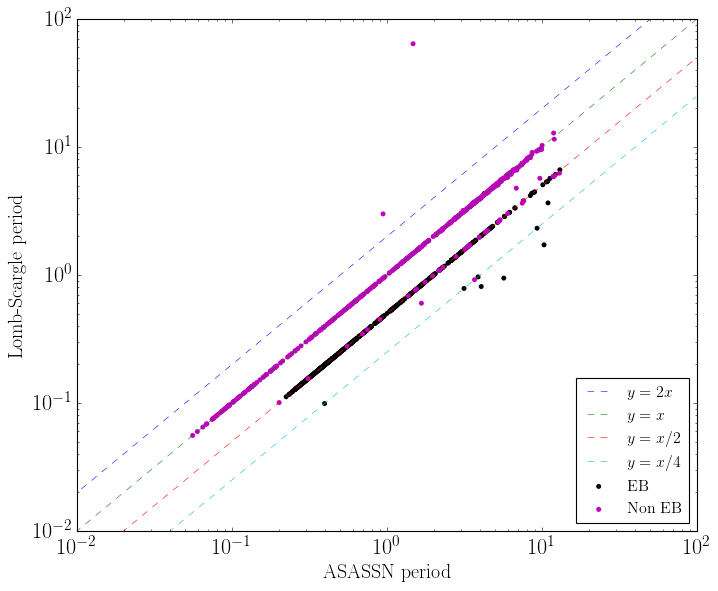

KeyError: 'pdm_period'

<Figure size 800x640 with 0 Axes>

In [283]:
s1 = sample[sample['type'].isin(['EA', 'EB', 'EW'])]
s2 = sample[~sample['type'].isin(['EA', 'EB', 'EW'])]

x = np.arange(0,100)
plt.figure(figsize=[10,8])
plt.scatter(s1['period'], s1['ls_period'], edgecolor='none', facecolor='k', label='EB')
plt.scatter(s2['period'], s2['ls_period'], edgecolor='none', facecolor='m', label='Non EB')
plt.plot(x,2*x, linewidth=.5, linestyle='--', label=r'$y=2x$')
plt.plot(x,x, linewidth=.5, linestyle='--', label=r'$y=x$')
plt.plot(x,x/2, linewidth=.5, linestyle='--', label=r'$y=x/2$')
plt.plot(x,x/4, linewidth=.5, linestyle='--', label=r'$y=x/4$')
plt.legend(loc='lower right', scatterpoints=1)
plt.xlabel('ASASSN period', fontsize=18)
plt.ylabel('Lomb-Scargle period', fontsize=18)
plt.xscale('log')
plt.yscale('log')
plt.xlim(.01,100)
plt.ylim(.01,100)
# plt.savefig('period_comparison.png')
plt.show()

x = np.arange(0,100)
plt.figure(figsize=[10,8])
plt.scatter(s1['period'], s1['pdm_period'], edgecolor='none', facecolor='k', label='EB')
plt.scatter(s2['period'], s2['pdm_period'], edgecolor='none', facecolor='m', label='Non EB')
plt.plot(x,2*x, linewidth=.5, linestyle='--', label=r'$y=2x$')
plt.plot(x,x, linewidth=.5, linestyle='--', label=r'$y=x$')
plt.plot(x,x/2, linewidth=.5, linestyle='--', label=r'$y=x/2$')
plt.plot(x,x/4, linewidth=.5, linestyle='--', label=r'$y=x/4$')
plt.legend(loc='lower right', scatterpoints=1)
plt.xlabel('ASASSN period', fontsize=18)
plt.ylabel('PDM period', fontsize=18)
plt.xscale('log')
plt.yscale('log')
plt.xlim(.01,100)
plt.ylim(.01,100)
# plt.savefig('period_comparison.png')
plt.show()

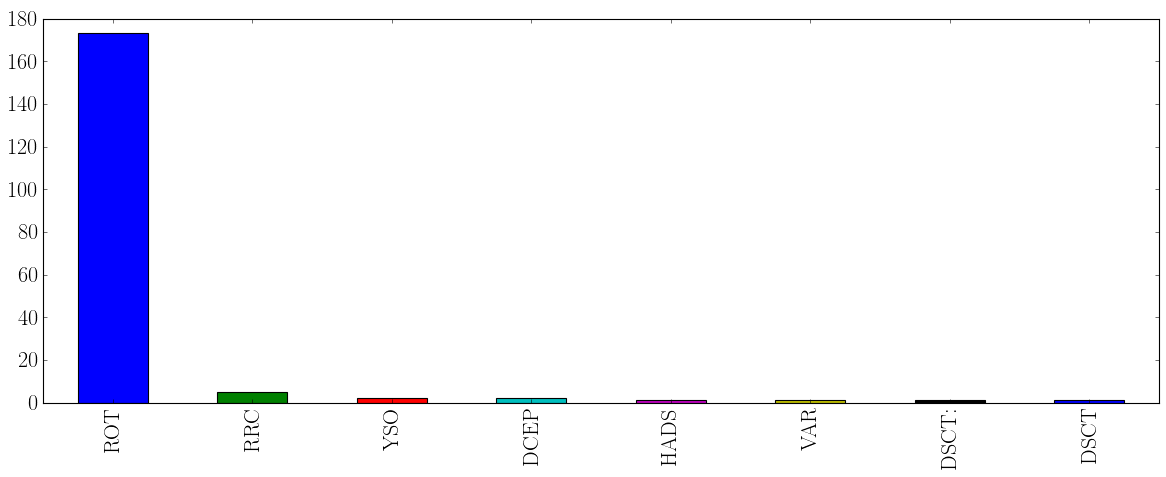

In [110]:
s2.query('pdm_period > period*1.1')['type'].value_counts().plot(kind='bar', figsize=[18,6])

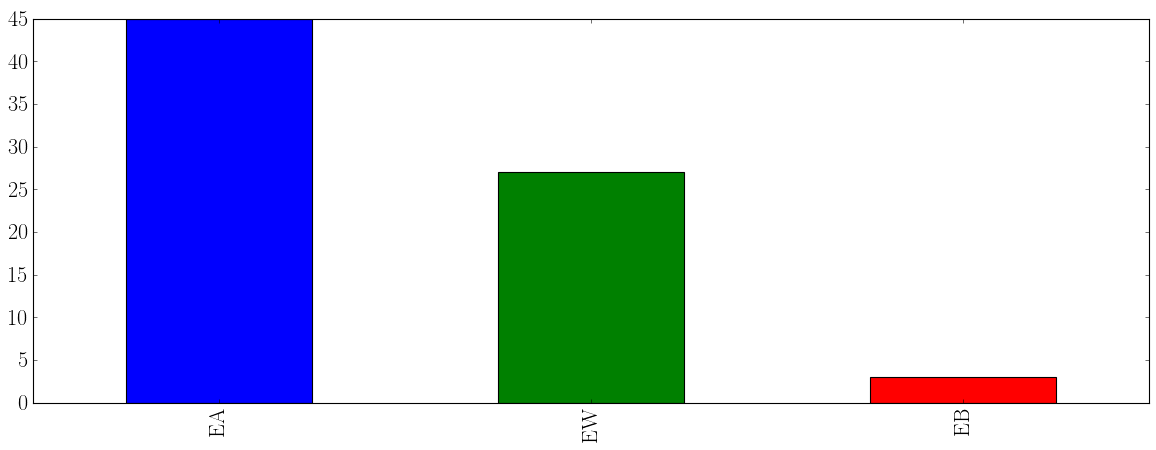

In [111]:
s1.query('pdm_period < .9*period')['type'].value_counts().plot(kind='bar', figsize=[18,6])

In [116]:
s1.query('pdm_period < .9*period')['tic_id'].index

Int64Index([   0,    3,   13,   17,   35,   77,  103,  120,  153,  155,  160,
             175,  183,  190,  213,  219,  229,  232,  274,  285,  295,  311,
             315,  325,  330,  338,  349,  353,  365,  370,  387,  393,  400,
             408,  454,  462,  490,  501,  528,  529,  531,  550,  551,  557,
             565,  590,  631,  634,  640,  769,  801,  816,  829,  831,  844,
             845,  851,  852,  858,  861,  872,  874,  879,  893,  904,  912,
             915,  939,  948,  952,  955,  966,  972, 1000, 1001],
           dtype='int64')

In [129]:
s2.query('pdm_period > period*1.1')['type'].index

Int64Index([ 11,  39,  43,  46,  54,  61,  63,  71,  88,  91,
            ...
            823, 849, 885, 898, 913, 925, 930, 992, 993, 996],
           dtype='int64', length=186)